In [1]:
# This cell only for package version control
import sys
import qiskit
import numpy
import matplotlib
print('python    :', sys.version)
print('qiskit    :',qiskit.__version__, qiskit.__qiskit_version__)
print('numpy     :',numpy.__version__)
print('matplotlib:',matplotlib.__version__)

python    : 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
qiskit    : 0.17.1 {'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}
numpy     : 1.20.2
matplotlib: 3.3.4


Kernel methods are widespread in machine learning and they were particularly common before deep learning became a dominant paradigm. The core idea is to introduce a new notion of distance between high-dimensional data points by replacing the inner product $(x_i, x_j)$ by a function that retains many properties of the inner product, yet which is nonlinear. This function $k(.,.)$ is called a kernel. Then, in many cases, wherever a learning algorithm would use an inner product, the kernel function is used instead.

The intuition is that the kernel function acts as an inner product on a higher dimensional space and encompasses some $\phi(.)$ mapping from the original space of the data points to this space. So intuitively, the kernel function is $k(x_i, x_j)=(\phi(x_i), \phi(x_j))$. The hope is that points that were not linearly separable in the original space become linearly separable in the higher dimensional space. The $\phi(.)$ function may map to an infinite dimensional space and it does not actually have to be specified. As long as the kernel function is positive semidefinite, the idea works.

Many kernel-based learning algorithms are instance-based, which means that the final model retains some or all of the training instances and they play a role in the actual prediction. Support vector machines belong here: support vectors are the training instances which are critically important in defining the boundary between two classes. Some important kernels are listed below.

| Name | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kernel function|
|------|-----------------|
|Linear | $(x_i,x_j)$|
|Polynomial| $((x_i,x_j)+c)^d$|
|Radial basis function|$\exp(-\gamma\|x_i-x_j\|^2)$|

The choice of kernel and the parameters of the kernel are often arbitrary and either some trial and error on the dataset or hyperparameter optimization helps choose the right combination. Quantum computers naturally give rise to certain kernels and it is worth looking at a specific variant of how it is constructed.

 # Thinking backward: learning methods based on what the hardware can do

Instead of twisting a machine learning algorithm until it only contains subroutines that have quantum variants, we can reverse our thinking and ask: given a piece of quantum hardware and its constraints, can we come up with a new learning method? For instance, interference is a very natural thing to do: we showed an option in the first notebook on quantum states, and it can also be done with a Hadamard gate. 
For this to work we need to encode both training and testvectors as amplitudes in a statevector built up out of four registers:

$|0\rangle_c|00..0\rangle_m|00..0\rangle_i|0\rangle_a$

The amplitude of such state will be equal to the value of a feature in a training vector or test vector. To do that we use four registers. The first is a single bit, acting as the ancilla ancilla (a), which will will code for either a training (a=0) or a testvector (a=1). The second register, in the notebook example a single bit, will code for the m-th training vector. The third register, in the notebook example also reduced to a single bit, codes for the i-th feature. Lastly the class bit (c) codes for class -1 (c=0), or 1 (c=1).
Hence, if after fully encoding all training data and test data into the state $|\psi>$ the state |1010> has coefficient 0.46 :

$|\psi\rangle\ = ....+ 0.46|1010\rangle +....$  ,

Then that implies that the second feature (i=1) of the first (m=0) training vector (a=0), which classifies as class 1 (c=1), has the value 0.46. Note, we assume both training vectors and test vector are normalized.

In a more general expression we can write for a fully encoded state (NB we arrange the order of the registers to be consistent with the code below):

$|\psi\rangle = \frac{1}{\sqrt{2M}}\sum_{m=0}^{M-1}|y_m\rangle|m\rangle|\psi_{x^m}\rangle|0\rangle + |y_m\rangle|m\rangle|\psi_{\tilde{x}}\rangle|1\rangle$

with:

$|\psi_{x^m}\rangle = \sum_{i=0}^{N-1}x_i^m|i\rangle, \; |\psi_{\tilde{x}}\rangle = \sum_{i=0}^{N-1}\tilde{x_i}|i\rangle. \quad$ N being equal to the number of features in the the training and test vectors

As the last summation is independent on m, there will M copies of the test vector in the statevector, one for every training vector.


We now only need to apply a Hadamard gate to the ancilla to interfere the test and training instances. Measuring and post-selecting on the ancilla gives rise to a kernel [[1](#1)].

Let's start with initializations:










In [2]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import BasicAer as Aer
import numpy as np

%matplotlib inline

np.set_printoptions(precision = 3)

q = QuantumRegister(4)
c = ClassicalRegister(4)
backend = Aer.get_backend('qasm_simulator')

We are constructing an instance-based classifier: we will calculate a kernel between all training instances and a test example. In this sense, this learning algorithm is lazy: no actual learning happens and each prediction includes the entire training set.

As a consequence, state preparation is critical to this protocol. We have to encode the training instances in a superposition in a register, and the test instances in another register. Consider the following training instances of the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris): $S = \{(\begin{bmatrix}0 \\ 1\end{bmatrix}, 0), (\begin{bmatrix}0.790 \\ 0.615\end{bmatrix}, 1)\}$, that is, one example from class 0 and one example from class 1. Furthermore, let's have two test instances, $\{\begin{bmatrix}-0.549\\ 0.836\end{bmatrix}, \begin{bmatrix}0.053 \\ 0.999\end{bmatrix}\}$. These examples were cherry-picked because they are relatively straightforward to prepare.

In [3]:
training_set = [[0, 1], [0.79, 0.615]]
labels = [0, 1]
test_set = [[-0.549, 0.836], [0.053 , 0.999]]


To load the data vectors, we use amplitude encoding as explained above, which means that, for instance, the second training vector will be encoded as $0.78861006|0\rangle + 0.61489363|1\rangle$. Preparing these vectors only needs a rotation, and we only need to specify the corresponding angles. The first element of the training set does not even need that: it is just the $|1\rangle$ state, so we don't specify an angle for it.

To get the angle we need to solve the equation $a|0\rangle + b|1\rangle=\cos\left(\frac{\theta}{2}\right)|0\rangle + i \sin \left(\frac{\theta}{2}\right) |1\rangle$. Therefore, we will use $\theta=2 \arccos(a)$

In [4]:
def get_angle(amplitude_0):
    return 2*np.arccos(amplitude_0)

In practice, the state preparation procedure we will consider requires the application of several rotations in order to prepare each data point in the good register. Don't hesitate to check it by yourself by running the circuit below with a pen and paper.

The following function builds the circuit. We plot it and explain it in more details below.

In [5]:
def prepare_state(q, c, angles):
    ancilla_qubit = q[0]
    index_qubit = q[1]
    data_qubit = q[2]
    class_qubit = q[3]
    circuit = QuantumCircuit(q, c)
    # Put the ancilla and the index qubits into uniform superposition
    circuit.h(ancilla_qubit)
    circuit.h(index_qubit)
    circuit.barrier()

    # Prepare the test vector
    circuit.cu(angles[0], 0, 0, 0, ancilla_qubit, data_qubit)
    # Flip the ancilla qubit > this moves the input 
    # vector to the |0> state of the ancilla
    circuit.x(ancilla_qubit)
    circuit.barrier()


    # Prepare the first training vector
    # [0,1] -> class 0
    # We can prepare this with a Toffoli
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    # Flip the index qubit > moves the first training vector to the 
    # |0> state of the index qubit
    circuit.x(index_qubit)
    circuit.barrier()

    # Prepare the second training vector
    # [0.790, 0.615] -> class 1
    #
    # Ideally we would do this with a double controlled, i.e a ccry, gate
    # However in qiskit we cannot build such a gate, hence we resort to
    # the following construction
    
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    circuit.ry(-angles[1], data_qubit)
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    circuit.ry(angles[1], data_qubit)
    circuit.barrier()

    # Flip the class label for training vector #2
    circuit.cx(index_qubit, class_qubit)
   
    return circuit

Let us see the circuit for the distance-based classifier:

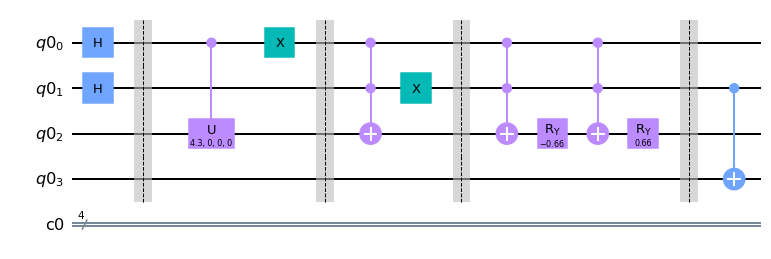

In [6]:
from qiskit.tools.visualization import circuit_drawer

# Compute the angles for the testvectors
test_angles = [get_angle(test_set[0][0]), get_angle(test_set[1][0])]
# Compute the angle for the second training vector (as the first vector is trivial)
training_angle = get_angle(training_set[1][0])/2

angles = [test_angles[0], training_angle]
state_preparation_0 = prepare_state(q, c, angles)
circuit_drawer(state_preparation_0, output='mpl')

The vertical lines are barriers to make sure that all gates are finished by that point. They also make a natural segmentation of the state preparation.

In the first section, the ancilla and index qubits are put into uniform superposition.

The second section entangles the test vector with the ground state of the ancilla.

In the third section, we prepare the state $|1\rangle$, which is the first training instance, and entangle it with the excited state of the ancilla and the ground state of the index qubit with a Toffoli gate and a Pauli-X gate. The Toffoli gate is also called the controlled-controlled-not gate, describing its action.

The fourth section prepares the second training instance and entangles it with the excited state of the ancilla and the index qubit. Next, the class qubit is flipped conditioned on the index qubit being $|1\rangle$. This creates the connection between the encoded training instances and the corresponding class label.

Let's dissect the last part where we prepare the second training state, which is $\begin{pmatrix}0.790 \\ 0.615\end{pmatrix}$ and we entangle it with the excited state of the ancilla and the excited state of the index qubit. We use `angles[1]`, which is ~`1.325/2`. Why? We have to rotate the basis state $|0\rangle$ to contain the vector we want. We could write this generic state as $\begin{pmatrix} \cos(\theta/2) \\ \sin(\theta/2)\end{pmatrix}$. Looking at the documentation of the gate implementing the rotation, you'll see that the function argument divides the angle by two, so we have to adjust for that -- this is why we divided $\theta$ by two. If you calculate the arccos or arcsin values, you will get the value in `angles[1]`.



We need to apply the rotation to data qubit only if ancilla AND index qubits are 1, in other words, we have to implement a double controlled rotation. Qiskit does not have this type of gate. Hence, we'll build it in two stages of half the required angle, designed in such a way they either add or cancel. The quantum AND gate is the CCX (also known as Toffoli), which flips the target qubit if both controls are 1. Applying the CCX flips only the data qbit of the target state. The subsequent rotation over half the desired angle works on all states, but after applying the second CCX the targed state has actually rotated in the opposite direction. Applying the reverse rotation adds the second half of the rotation for the target state,ans cancels the rotation for all other states (See Bloch sphere diagram outlining these 4 steps)


![Bloch sphere](../figures/blochsphere.jpg)



<br>
Let's now see what final state the circuit has produced. Note, the print is a non-normalized statevector:

In [7]:
val = ['Xtest x', 'Xtrn0 x','','','Xtest y','Xtrn0 y','','','','','Xtest x','Xtrn1 x','','','Xtest y','Xtrn1 y']
res = execute(state_preparation_0, Aer.get_backend('statevector_simulator')).result()
outp = 2* np.array(np.real(res.get_statevector(state_preparation_0)))
print('Statevector after insertion of data and testvectors\n\ncdia   coefficient')
for z in range(outp.shape[0]):
    print(format(z, '04b'),'    % 5.4f   ' %(round(outp[z],3)), val[z])

Statevector after insertion of data and testvectors

cdia   coefficient
0000     -0.5490    Xtest x
0001      0.0000    Xtrn0 x
0010      0.0000    
0011      0.0000    
0100      0.8360    Xtest y
0101      1.0000    Xtrn0 y
0110      0.0000    
0111      0.0000    
1000      0.0000    
1001      0.0000    
1010     -0.5490    Xtest x
1011      0.7900    Xtrn1 x
1100      0.0000    
1101      0.0000    
1110      0.8360    Xtest y
1111      0.6130    Xtrn1 y


From the table you can see how both the test vector (Xtst x, Xtsty), as well as the training vectors ((Xtrn0 x, Xtrn0 y) - class0) and ((Xtrn1 x,Xtrn1 y) - class1) are embedded in the state vector. The training vector class is indicated in the class bit (c). The test vector is coded by the 0-state of the ancilla (a), and the training vector is coded by the 1-state of the ancilla. Note also the data bit (d) coding for the value of the x or y feature of the training vectors, and the index bit (i) coding for training vector 1 or 2.

We are now ready for the final step

# A natural kernel on a shallow circuit

Having done the state preparation, the actual prediction is nothing but a Hadamard gate applied on the ancilla, followed by measurements. Since the ancilla is in a uniform superposition at the end of the state preparation and it is entangled with the registers encoding the test and training instances, applying a second Hadamard on the ancilla interferes the entangled registers. The state before the measurement is  $\frac{1}{2\sqrt{M}}\sum_{m=0}^{M-1}|y_m\rangle|m\rangle(|\psi_{x^m}\rangle+|\psi_{\tilde{x}}\rangle)|0\rangle+|y_m\rangle|m\rangle(|\psi_{x^m}\rangle-|\psi_{\tilde{x}}\rangle)|1\rangle$, where $|\psi_{\tilde{x}}\rangle$ is the encoded test instance and $\psi_{x^m}\rangle$ is the m-th training instance. For our example M, the number of training samples, equals 2.



In [8]:
def interfere_data_and_test_instances(circuit, q, c, angles):
    circuit.h(q[0])
    circuit.barrier()
    circuit.measure(q, c)
    return circuit

If we measure the ancilla, the outcome probability of observing 0 will be $\frac{1}{4M}\sum_{i=0}^{M-1} |\tilde{x} + x_m|^2$. This creates a kernel of the following form:

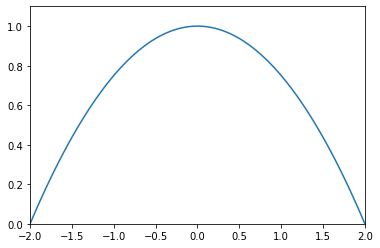

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = np.linspace(-2, 2, 100)
plt.xlim(-2, 2)
plt.ylim(0, 1.1)
plt.plot(x, 1-x**2/4)

This is the kernel that performs the classification. We perform the post-selection on observing 0 on the measurement on the ancilla and calculate the probabilities of the test instance belonging to either class:

In [10]:
def postselect(result_counts):
    total_samples = sum(result_counts.values())

    # define lambda function that retrieves only results where the ancilla is in the |0> state
    post_select = lambda counts: [(state, occurences) for state, occurences in counts.items() if state[-1] == '0']

    # perform the postselection
    postselection = dict(post_select(result_counts))
    postselected_samples = sum(postselection.values())
    ancilla_post_selection = postselected_samples/total_samples

    print('Ancilla post-selection probability was found to be ',round(ancilla_post_selection,3))
    retrieve_class = lambda binary_class: [occurences for state, occurences in postselection.items() if state[0] == str(binary_class)]

    prob_class0 = sum(retrieve_class(0))/postselected_samples
    prob_class1 = sum(retrieve_class(1))/postselected_samples

    print('Probability for class 0 is', round(prob_class0,3))
    print('Probability for class 1 is', round(prob_class1,3))

For the first instance we have:

In [11]:
circuit_0 = interfere_data_and_test_instances(state_preparation_0, q, c, angles)
job = execute(circuit_0, backend)
result = job.result()
count = result.get_counts(circuit_0)
print(count)
postselect(count)

{'0100': 432, '1011': 224, '1110': 278, '0001': 43, '0000': 40, '1010': 4, '1111': 3}
Ancilla post-selection probability was found to be  0.736
Probability for class 0 is 0.626
Probability for class 1 is 0.374


And for the second one:

In [12]:
angles = [test_angles[1], training_angle]
state_preparation_1 = prepare_state(q, c, angles)
circuit_1 = interfere_data_and_test_instances(state_preparation_1, q, c, angles)
job = execute(circuit_1, backend)
result = job.result()
count = result.get_counts(circuit_1)
print(count)
postselect(count)

{'1010': 104, '1110': 324, '0100': 517, '1111': 17, '1011': 62}
Ancilla post-selection probability was found to be  0.923
Probability for class 0 is 0.547
Probability for class 1 is 0.453


# References

[1] M. Schuld, M. Fingerhuth, F. Petruccione. (2017). [Implementing a distance-based classifier with a quantum interference circuit](https://doi.org/10.1209/0295-5075/119/60002). *Europhysics Letters*, 119(6), 60002. <a id='1'></a>